# <font color="1318A3"> HOSMANN PROJECT </font>

## <font color="1318A3"> 00. Import libraries</font>

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb

import inflection
import math
import datetime
import pickle
import matplotlib.gridspec as gridspec
import random
import warnings

from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from scipy                 import stats as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler        # promo_time_week
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error

from IPython.display       import Image
# from IPython.core.display import HTML


## <font color="1318A3">01. Function</font>

In [2]:
#Ignore warning
warnings.filterwarnings( 'ignore')

In [ ]:
#def jupyter_settings():
#    %matplotlib inline
#    %pylab inline
#    
#    plt.style.use( 'bmh' )
#    plt.rcParams['figure.figsize'] = [25, 12]
#    plt.rcParams['font.size'] = 24

#    display( HTML( '<style>.container { width:100% !important; }</style>') )
#    pd.options.display.max_columns = None
#    pd.options.display.max_rows = None
#    pd.set_option( 'display.expand_frame_repr', False )
#    sns.set()


In [ ]:
#jupyter_settings() 


### <font color="1318A3">001. Cramer V Function</font>

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values 
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) ) 


### <font color="1318A3"> 002. Mean Percentage Error Function</font>

In [4]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


### <font color="1318A3"> 003. Mean Absolute Percentage Error Function</font>

In [5]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )


### <font color="1318A3">004. ml_Error Function</font>

In [6]:
def ml_error( model_name, y, yhat ):
    mae  = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )


### <font color="1318A3">005. Cross Validation Function</font>

In [7]:
def cross_validation( x_training, kfold, model_name , model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        
        if verbose:
            print( '\nKFold Number:{}'. format( k ))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )   # First 6 week
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 ) # Last date

        # filtering dataset
        training = x_training[ x_training['date'] < validation_start_date ]
        validation = x_training[ ( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date) ]
    
        # training and validation
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
    
        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation), np.expm1( yhat ))
    
        # stores performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    # Creating a dictionary for calculating the average
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE CV': np.round( np.mean( mae_list ), 2).astype(str) + ' +/- ' + np.round( np.std( mae_list), 2).astype(str),
                           'MAPE CV': np.round( np.mean( mape_list ), 2).astype(str) + ' +/- ' + np.round( np.std( mape_list), 2).astype(str),
                           'RMSE CV': np.round( np.mean( rmse_list ), 2).astype(str) + ' +/- ' + np.round( np.std( rmse_list), 2).astype(str) }, index=[0] )
       

## <font color="1318A3">0.2 Loading Data </font>

In [8]:
# Data Sales
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )

# Data Store
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store' )


In [9]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
77678,744,6,2015-05-23,8206,878,1,0,0,0,a,a,1370.0,12.0,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# <font color="1318A3">1.0 - DATA DESCRIPTION</font>

In [10]:
df1 = df_raw.copy()

## <font color="1318A3">1.1. Rename Columns</font> 

In [11]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [12]:
# format columns name to snakecase
cols_old =['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
           'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old) )

# rename columns
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## <font color="1318A3">1.2. Data Dimensions</font>

In [13]:
# Show Data Dimensions
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )


Number of Rows: 1017209
Number of cols: 18


## <font color="1318A3">1.3. Data Types</font>

In [14]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [15]:
df1['date'] = pd.to_datetime( df1['date'] )


In [16]:
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## <font color="1318A3">1.4. Check NA</font>

In [17]:
# Checking NAN values
df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## <font color="1318A3">1.5. Fillout NA</font>

In [18]:
df1.sample()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
121736,202,1,2015-04-13,8229,668,1,1,0,0,d,c,5140.0,5.0,2010.0,0,NaN,NaN,NaN


In [19]:
#  competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#  competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#  competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#  promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#  promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#  promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna( 0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0 , axis=1)


In [20]:
df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [21]:
df1.sample(5).T


,797908,761502,709819,325407,823909
store,354,743,350,248,710
day_of_week,2,7,4,6,7
date,2013-07-16 00:00:00,2013-08-18 00:00:00,2013-10-03 00:00:00,2014-09-27 00:00:00,2013-06-23 00:00:00
sales,9391,0,0,6689,0
customers,696,0,0,984,0
open,1,0,0,1,0
promo,1,0,0,0,0
state_holiday,0,0,a,0,0
school_holiday,0,0,0,0,0
store_type,d,a,d,a,d


## <font color="1318A3">1.6. Change Types</font>

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')


In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## <font color="1318A3">1.7. Descriptive Statistical</font>

In [24]:
# numeric variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'])

# categorical variables
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]']) 


### <font color="Blue">1.7.1 Numerical Attributes</font>

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T
                   
# Dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T
                                        
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# rename columns
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']


In [26]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

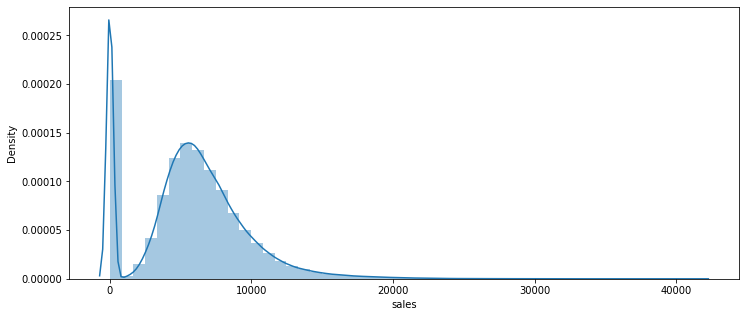

In [27]:
plt.figure( figsize=(12 , 5 ) )
sns.distplot(df1['sales'])


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

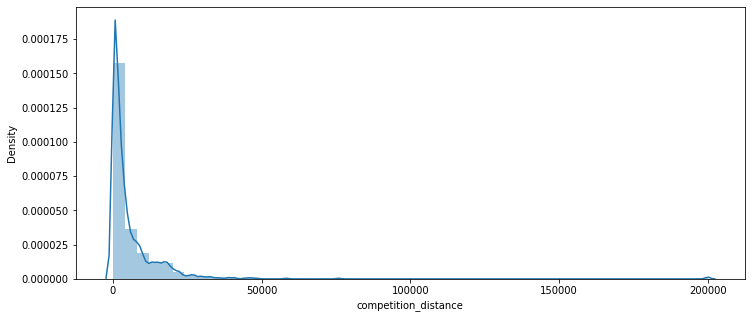

In [28]:
# plt.figure( figsize=(10,5) )
# plt.subplot(1, 1, 1)
plt.figure( figsize=(12, 5) )
sns.distplot( df1['competition_distance'] )


### <font color="Blue">1.7.2 Categorical Attributes</font>

In [29]:
# checking categorical variables
cat_attributes.apply( lambda x: x.unique().shape[0])


state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

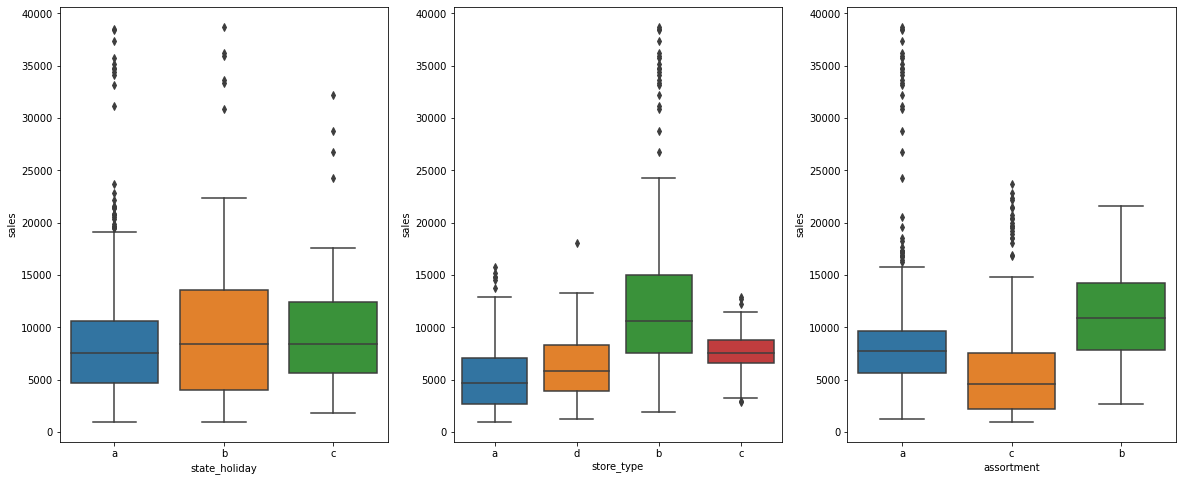

In [30]:
# Viewing the distribution by sales

aux = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure( figsize=(20,8) )
plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data= aux)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux)


# <font color="1318A3">2.0 - FEATURE ENGINEERING</font>

## <font color="1318A3">2.1. Mind Map Hypothesis</font>

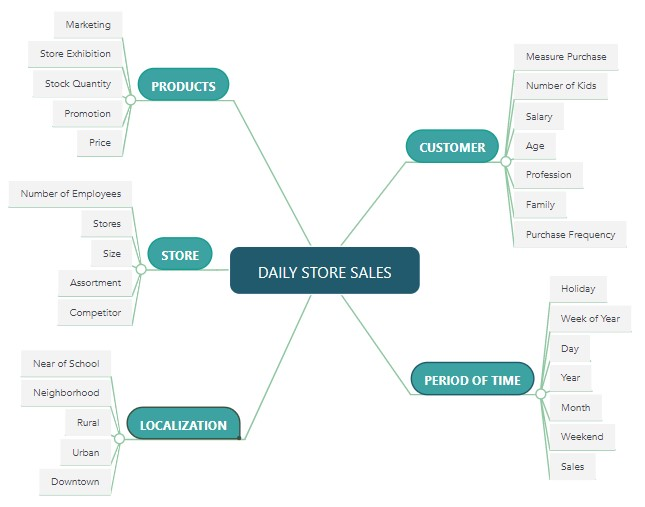

In [31]:
# Import Mind Map image
Image('img/mindmeister_Hossmann.jpg')

## <font color="1318A3">2.2 Create Hypothesis</font>

In [32]:
df2 = df1.copy()


### <font color="1318A3">2.1.1. Hypothesis for Store</font>

**1.**   Stores with more employees should sell more.

**2.**   Stores with greater inventory should sell more.

**3.**   Larger stores should sell more.

**4.**   Stores with larger assortments should sell more.

**5.**   Stores with closer competitors should sell less.

**6.**   Stores with longer competitors should sell more.


### <font color="1318A3">2.1.2. Hypothesis for Product<font>

**1.**   Stores that invest more in Marketing should sell more.

**2.**   Stores with greater product exposure should sell more.

**3.**   Stores with lower priced products should sell more.

**5.**   Stores with more aggressive promotions (bigger discounts) should sell more.

**6.**   Stores with longer active promotions should sell more.

**7.**   Stores with more days of promotion should sell more.

**8.**   Stores with more consecutive promotions should sell more.


### <font color="1318A3">2.1.3. Hypothesis Period of Time</font>

**1.**   Stores open during the Christmas holiday should sell more.

**2.**   Stores should sell more over the years.

**3.**   Stores should sell more in the second half of the year.

**4.**   Stores should sell more after the 10th of each month.

**5.**   Stores should sell less on weekends.

**6.**   Stores should sell less during school holidays.


### <font color="1318A3"> 2.2. Hypothesis Final List</font>

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.


**4.** Stores with longer active promotions should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## <font color="1318A3">2.3 Feature Engineering</font>

In [33]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = (( df2['date'] -  df2['promo_since'])/7).apply(lambda x: x.days).astype( int )


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x =='b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x =='b' else 'christmas' if x =='c' else 'regular_day' )


In [34]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [35]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# <font color="1318A3">3.0 - VARIABLE FILTERING<font>

In [36]:
df3 = df2.copy()


## <font color="1318A3">3.1. Lines Filtering<font>

In [37]:
# Open = 0 ( Store closed)
df3 = df3[(df3['open'] !=0) & (df3['sales']>0 ) ]


## <font color="1318A3">3.2. Columns Filtering<font>

In [38]:
cols_drop =['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)


# <font Color="1318A3"> 4.0 - EXPLORATORY DATA ANALYSIS (EDA)<font>

In [39]:
df4=df3.copy()


### <font color="1318A3"> 4.1.1. Response Variable <font>

<AxesSubplot:xlabel='sales', ylabel='Density'>

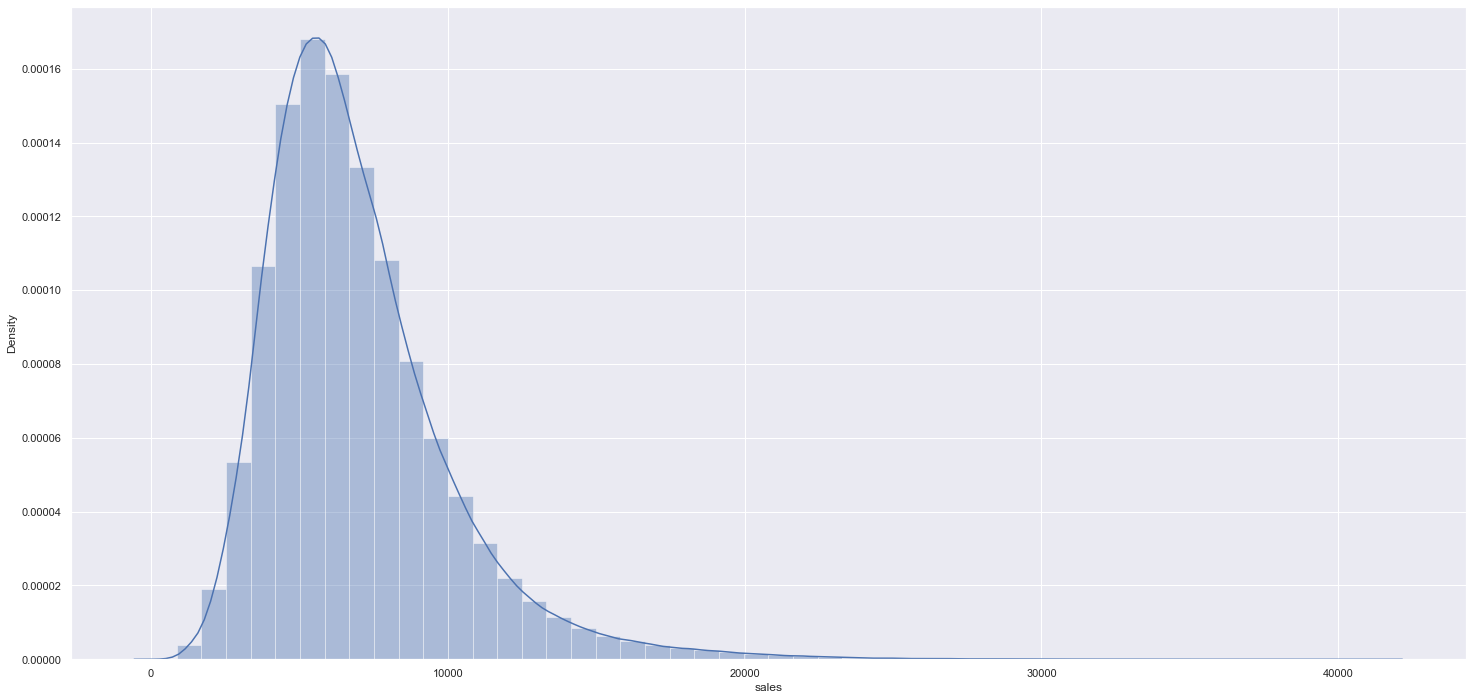

In [151]:
sns.distplot( df4['sales'] )


### <font color="1318A3"> 4.1.2. Numerical Variable <font>

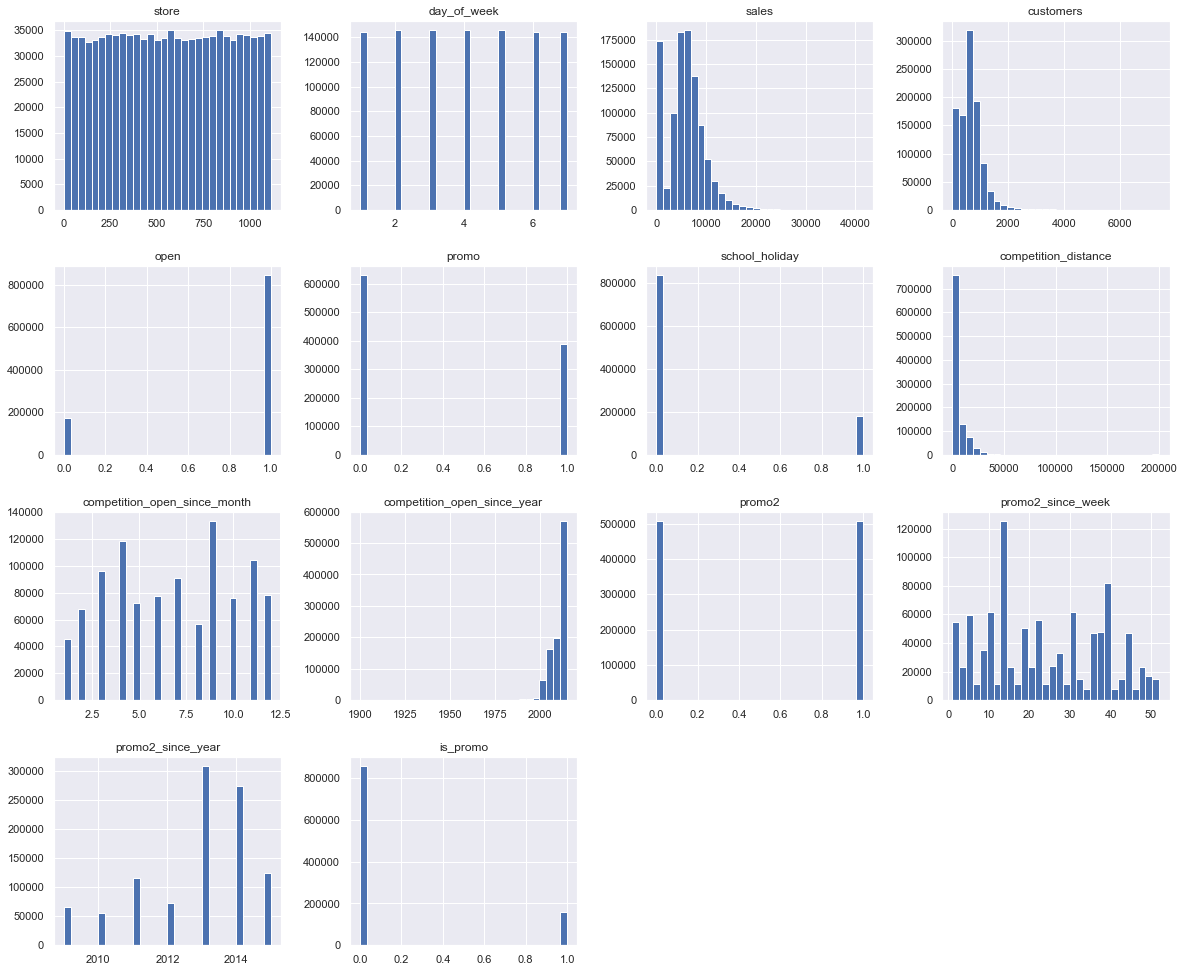

In [168]:
num_attributes.hist( bins = 30, figsize = (20,17));


### <font color="1318A3"> 4.1.3. Categorical Variable <font>

In [45]:
df4['state_holiday'].drop_duplicates()


0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='state_holiday', ylabel='count'>

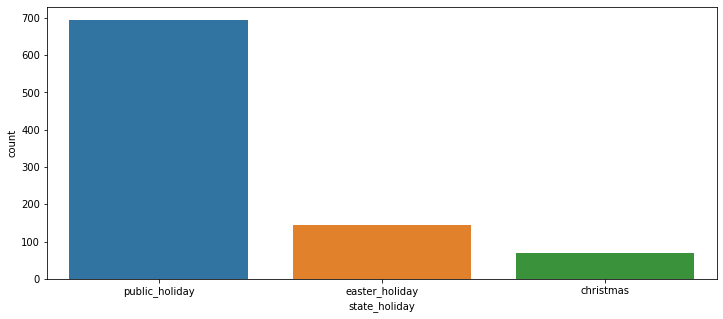

In [46]:
# State Holiday
plt.figure( figsize=(12, 5))
a = df4[ df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'])


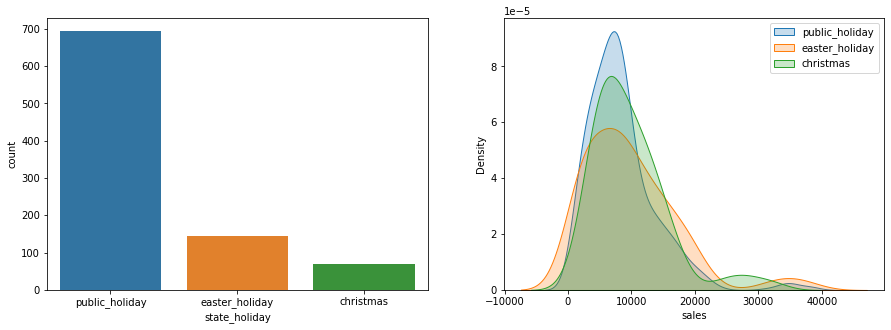

In [47]:
# State Holiday
plt.figure( figsize=( 15, 5))
plt.subplot(1,2,1)
a = df4[ df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'])

plt.subplot(1,2,2)
sns.kdeplot( df4[ df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[ df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[ df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()


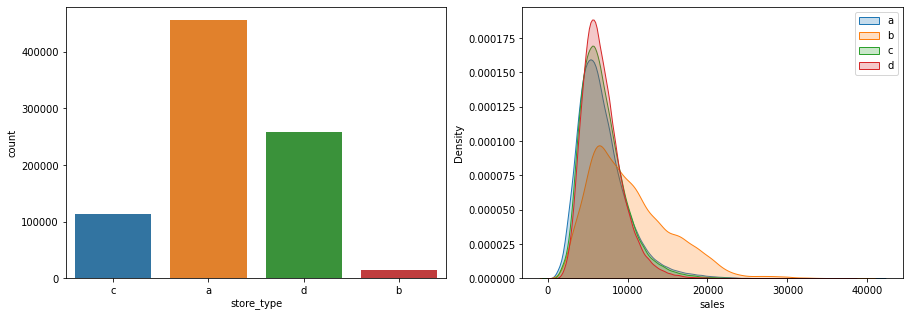

In [48]:
# store Type
plt.figure( figsize=( 15, 5))
plt.subplot(1,2,1)
sns.countplot( df4['store_type'])

plt.subplot(1,2,2)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()


In [49]:
df4['assortment'].drop_duplicates()


0         basic
3      extended
258       extra
Name: assortment, dtype: object

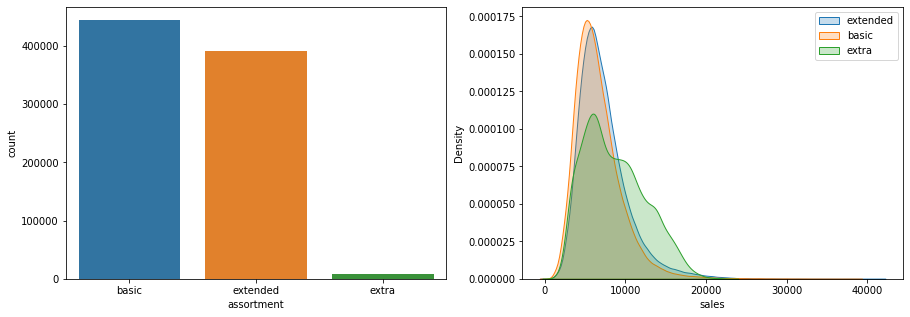

In [50]:
# assortment
plt.figure( figsize=( 15, 5 ))
plt.subplot(1,2,1)
sns.countplot( df4['assortment'])

plt.subplot(1,2,2)
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()


## <font color="1318A3"> 4.1. Univariate Analysis<font>

## <font color="1318A3"> 4.2. Bivariate Analysis<font>

### <font color="1318A3"> H1. Stores with bigger assortments should sell more.</font>

### FALSE : Store with BIGGER assortments sell LESS.

<AxesSubplot:xlabel='year_week'>

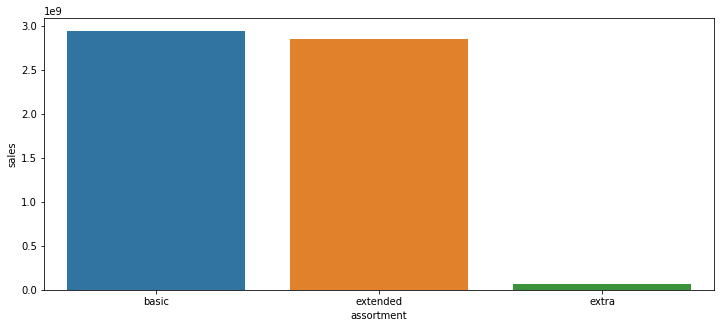

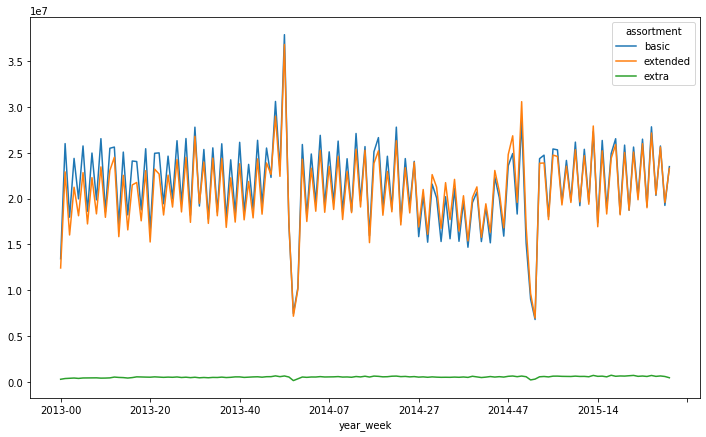

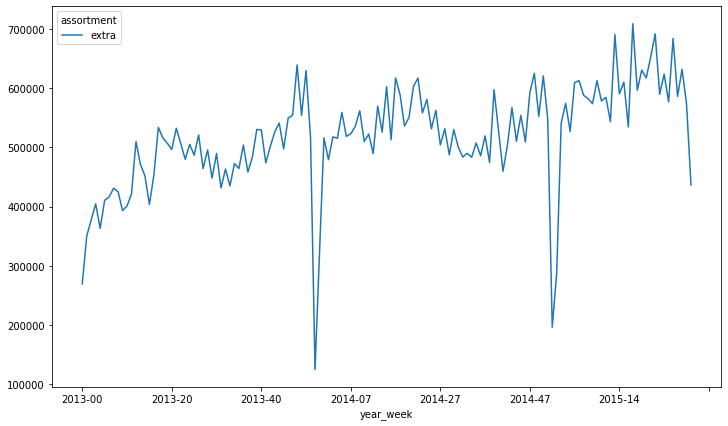

In [51]:
# check each assortment per sales
plt.figure( figsize=(12, 5 ))
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

# check year_week per assortment sales
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot( figsize=(12,7))

# check extra assortment per yea_week
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot( figsize=(12, 7))

### <font color="1318A3"> H2. Store with closer competitors should sell less.</font> 

### FALSE: Store with closer competitors sell more.

<Figure size 720x864 with 0 Axes>

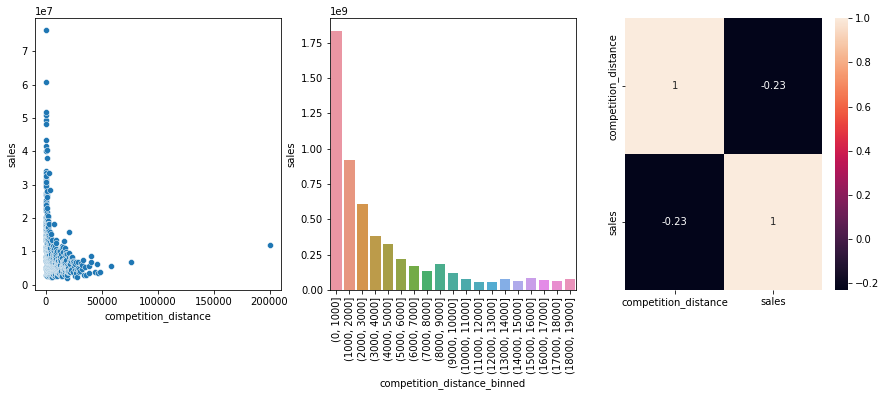

<Figure size 720x864 with 0 Axes>

In [52]:
# scatter plot sales per competition distance
plt.figure( figsize=(15, 5))
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance').sum().reset_index()
plt.subplot( 1,3,1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1);

# barplot with bins
plt.subplot( 1, 3, 2)
bins = list(np.arange(0, 20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation = 90);

# correlation heatmap
plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);
plt.figure(figsize=(10,12))


### <font color="1318A3"> H3. Store with longer competitor should sell more.<font>
    
### FALSE: Store with longer competitor sell less.

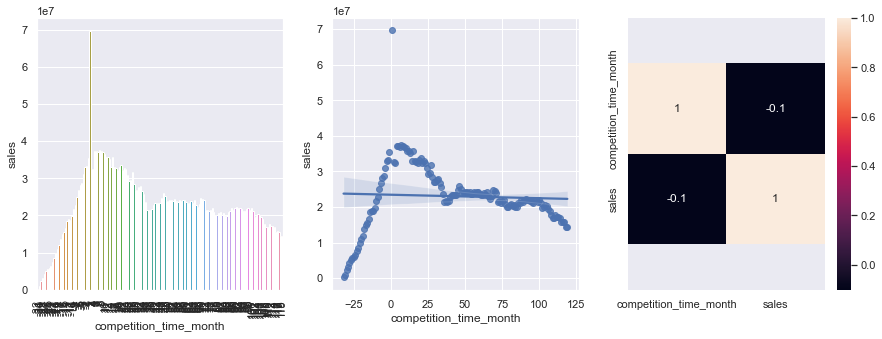

In [225]:

# barplot for sales per competition_time_month
plt.figure( figsize=(15,5))
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] !=0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);

plt.xticks( rotation=90 );

# scatter for sales per competition_time_month
#plt.figure( figsize=(25,8))
plt.subplot( 1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

# correlation sales per competition_time_month
plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);



### <font color="1318A3">H4. Store with active promotions should sell more.</font>

### FALSE: After some period of promotion. Stores with longer active promotions sell less.


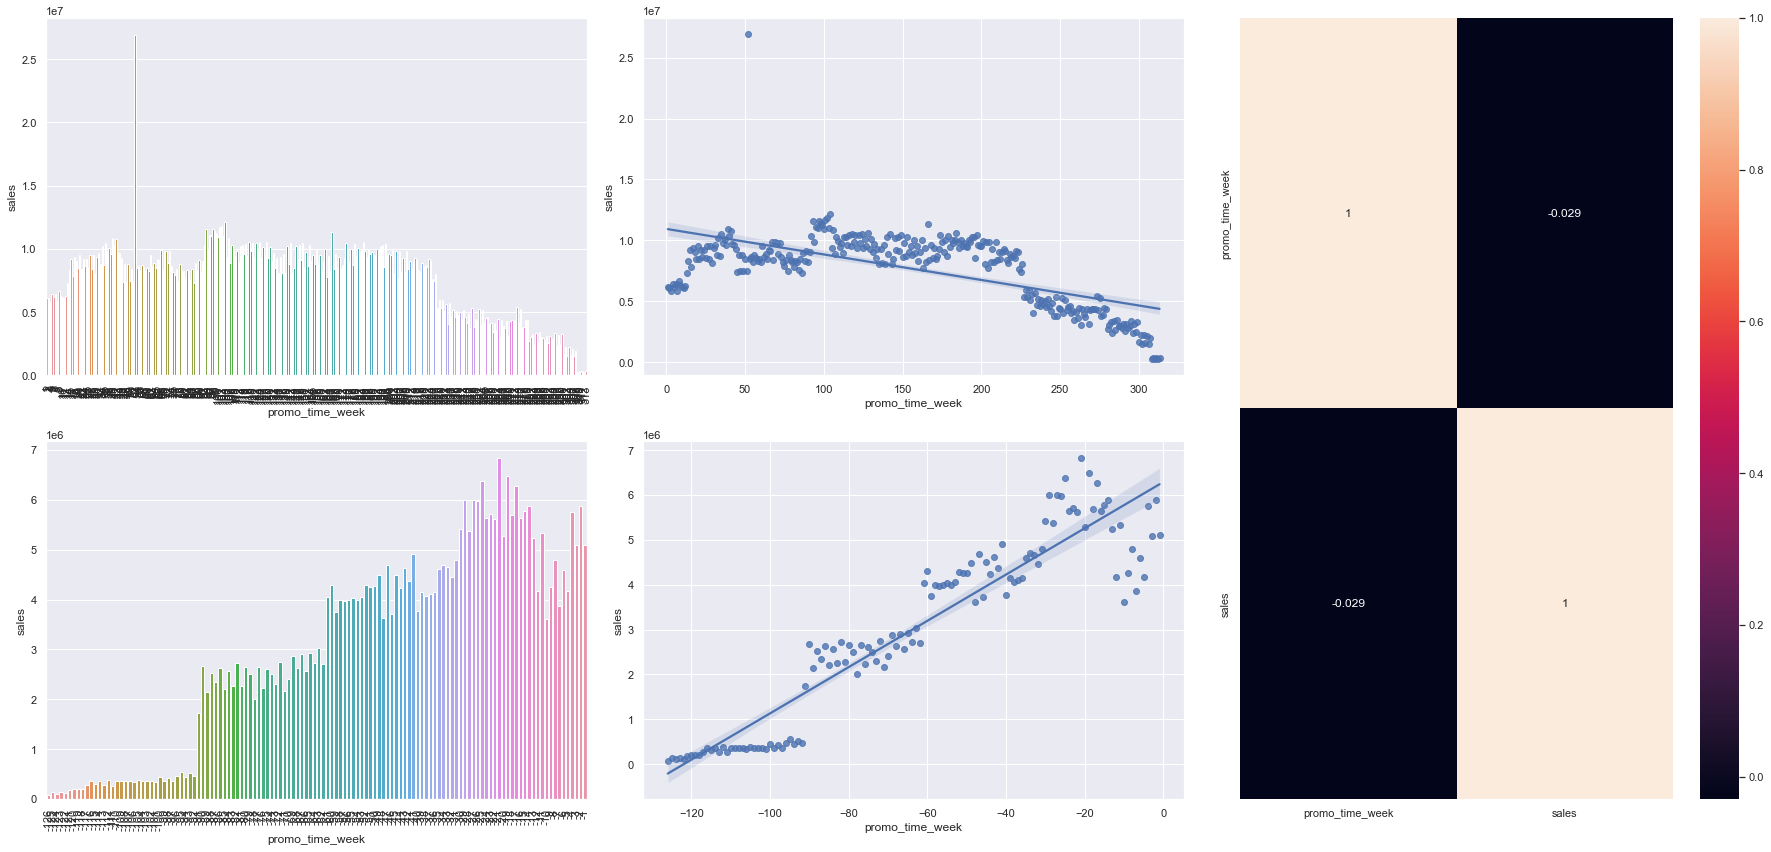

In [173]:

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = gridspec.GridSpec(2, 3)

# extended promo period
plt.subplot( grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # Extended Promotions
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2)

# regular promo period
plt.subplot( grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # Regular Promotions
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90);

plt.subplot( grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

# correlation sales - promo_time_week
plt.subplot( grid[:,2] )
sns.heatmap(aux1.corr( method = 'pearson'), annot=True)

plt.tight_layout() 


### <font color="1318A3">H5. Stores with extended promotions should sell more.</font>


### <font color="1318A3">H7. Stores with extended promotions should sell more.</font>

### False: Stores with extended promotions sell less.

In [56]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<Figure size 1080x576 with 0 Axes>

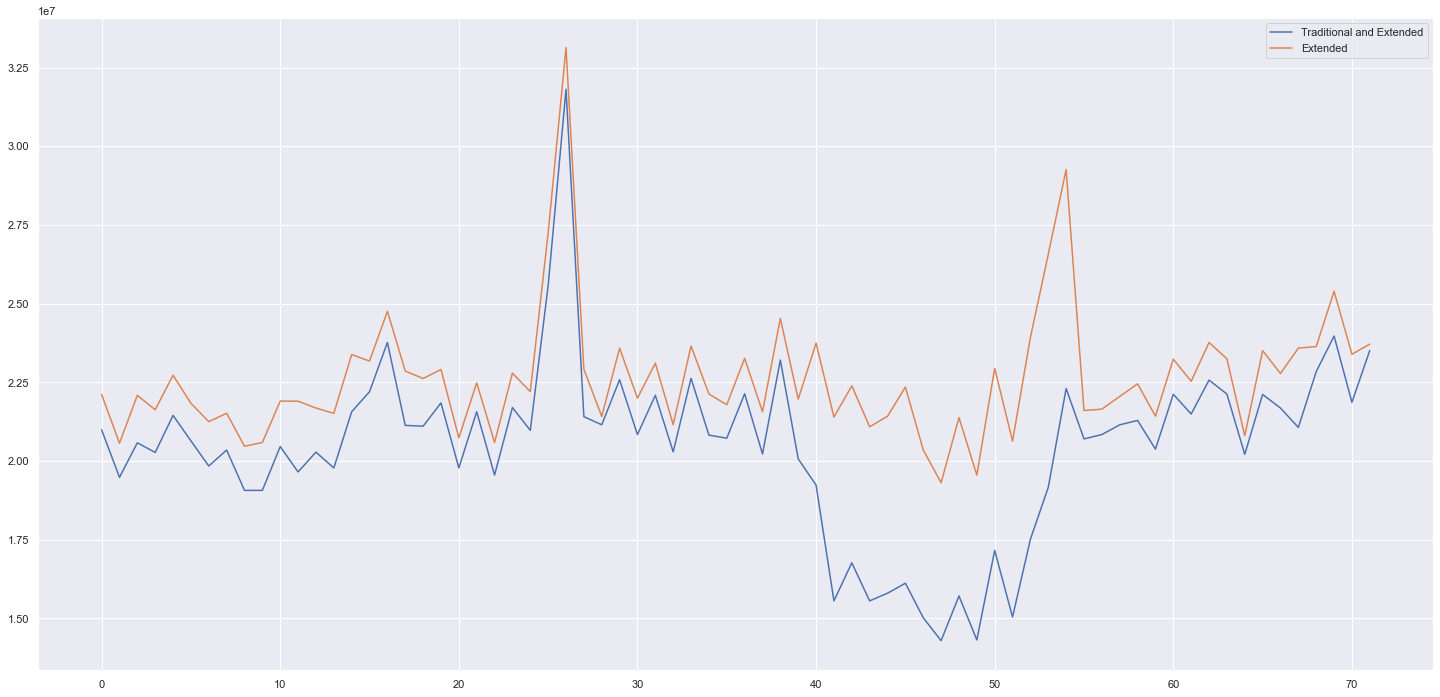

In [176]:
plt.figure( figsize=(15,8))

# regular and extended promo
aux1 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# regular promo
aux2 = df4[( df4['promo'] ==1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax)
ax.legend( labels=['Traditional and Extended', 'Extended']);


### <font color="1318A3">H7. Stores open during the Christmas holiday should sell more.</font>

### False: Store open during the Christmas holiday sell less.


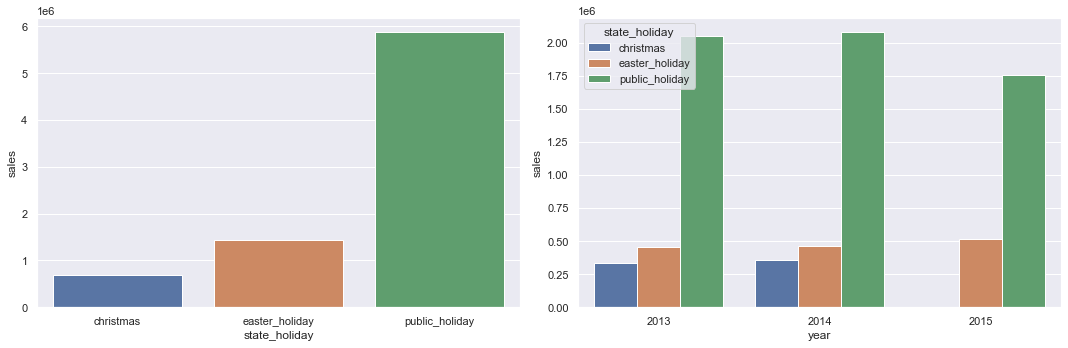

In [177]:

# sales per holiday
aux = df4[ df4['state_holiday'] != 'regular_day'] # remove regulary day
plt.figure( figsize=(15,5))
plt.subplot( 1,2,1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1)

# sales per holiday by year
plt.subplot( 1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

plt.tight_layout() 


### <font color="1318A3">H8. Stores should sell more over the years.</font>

### FALSE: Store sell less.


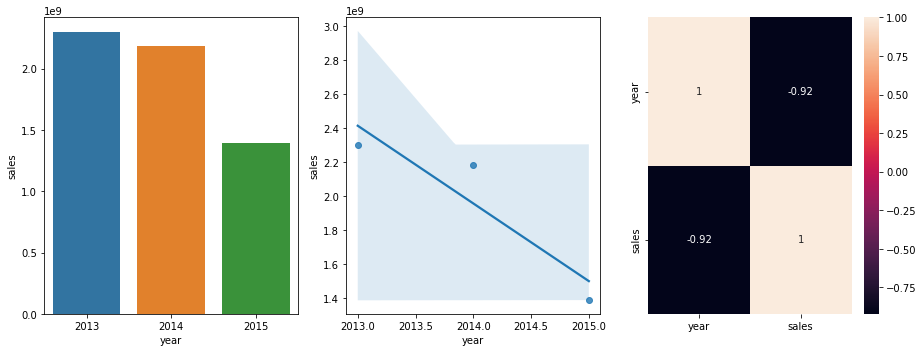

In [59]:
aux1 = df4[['year', 'sales']].groupby( 'year').sum().reset_index()
plt.figure( figsize=(13,5))

# bar plot: sales per year
plt.subplot(1,3,1)
sns.barplot( x='year', y='sales', data=aux1);

# scatter plot: sales per year
plt.subplot(1,3,2)
sns.regplot( x='year', y='sales', data=aux1);

# correlation: year per sales
plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );
plt.tight_layout() 


### <font color="1318A3">H9. Stores should sell more in the second half of the year.</font>

### FALSE: Stores sell less in the second half of the year


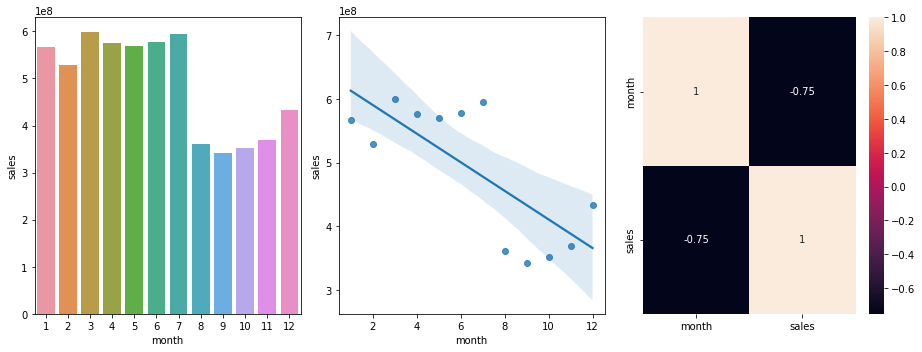

In [60]:
aux1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()
plt.figure( figsize=(13,5))

# bar plot: sales per month
plt.subplot(1,3,1)
sns.barplot( x='month', y='sales', data=aux1);

# scatter plot: sales per month
plt.subplot(1,3,2)
sns.regplot( x='month', y='sales', data=aux1);

# correlation: month per sales
plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout() 


### <font color="1318A3">H10. Stores should sell more after the 10th of each month.</font>

### True: Stores sell more after 10th of each month. 


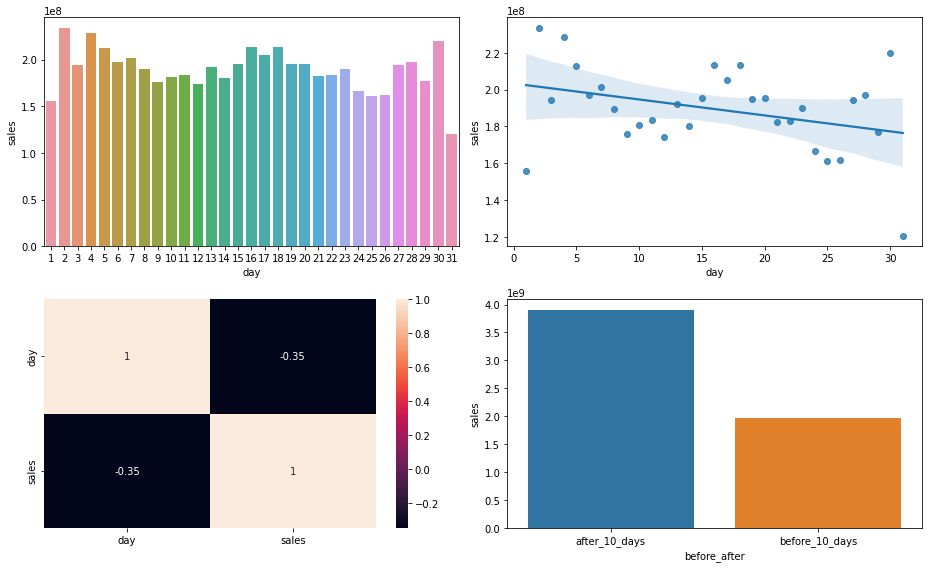

In [61]:
# working with period of 10th.
aux1 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()
plt.figure( figsize=(13,8))

# bar plot: sales per day
plt.subplot(2,2,1)
sns.barplot( x='day', y='sales', data=aux1);

# scatter plot: sales per day
plt.subplot(2,2,2)
sns.regplot( x='day', y='sales', data=aux1);

# correlation: day per sales
plt.subplot(2,2,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

# bar plot sales before the 10th and after the 10th
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
                                               
plt.subplot(2,2,4)
sns.barplot( x='before_after', y='sales', data=aux2);

plt.tight_layout() 

### <font color="1318A3">H11. Store should sell less on weekend.

### True. Store sell less on weekend.

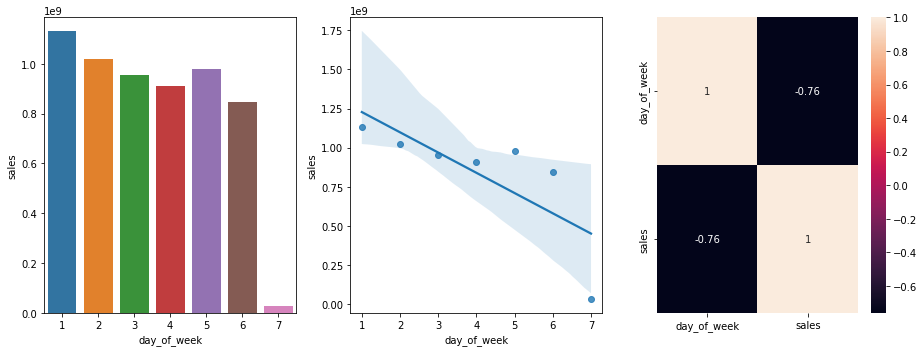

In [62]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()
plt.figure( figsize=(13,5))

# bar plot sales per day of week
plt.subplot(1,3,1)
sns.barplot( x='day_of_week', y='sales', data=aux1);

# scatter plot sales per day of week
plt.subplot(1,3,2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

# correlation: sales per day of week
plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.tight_layout() 

### <font color="1318A3">H12. Stores should sell less during holidays school.</font>

### TRUE: Store sell less during holidays school. except the months of July and August.


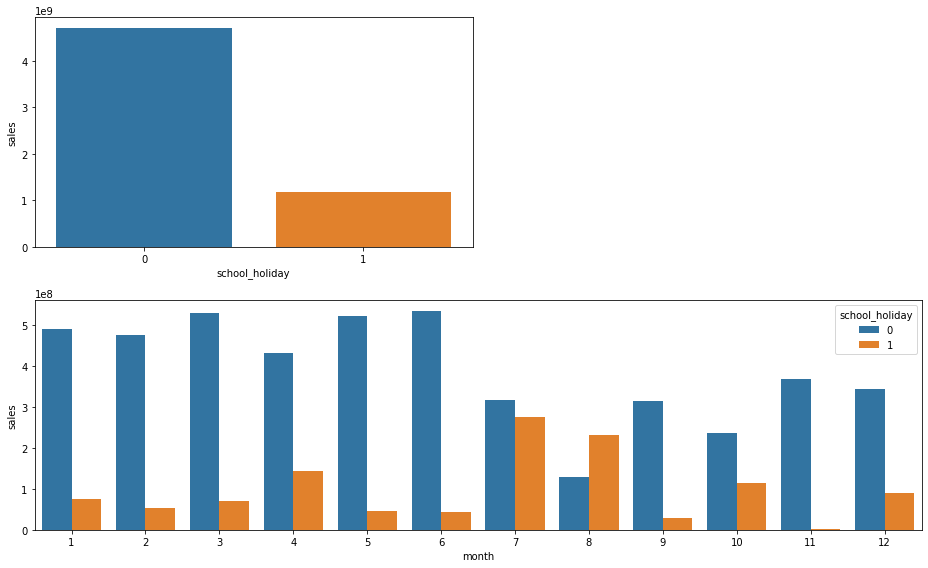

In [63]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday').sum().reset_index()
plt.figure( figsize=(13,8))

# bar plot: sales per school_holiday
plt.subplot(2,2,1)
sns.barplot( x='school_holiday', y='sales', data=aux1);

# bar plot: sales per school_holiday, month
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2);

plt.tight_layout() 

In [64]:
tab = [['Hipotese', 'Conclusao', 'Relevancia'],
       ['H1', 'False', 'Baixa'],
       ['H2', 'False', 'Media'],
       ['H3', 'False', 'Media'],
       ['H4', 'False', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'False', 'Baixa'],
       ['H8', 'False', 'Media'],
       ['H9', 'False', 'Alta'],
       ['H10', 'False', 'Alta'],
       ['H11', 'True', 'Alta'],
       ['H12', 'True', 'Alta'],
       ['H13', 'True', 'Baixa'],
      ]
print( tabulate( tab, headers = 'firstrow'))
       

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          False        Baixa
H2          False        Media
H3          False        Media
H4          False        Baixa
H5          -            -
H7          False        Baixa
H8          False        Media
H9          False        Alta
H10         False        Alta
H11         True         Alta
H12         True         Alta
H13         True         Baixa


## <font color="1318A3">4.3. Multivariate analysis<font>

### <font color="1318A3">4.3.1. Numerical Attributes</font>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'store'),
  Text(1.5, 0, 'day_of_week'),
  Text(2.5, 0, 'sales'),
  Text(3.5, 0, 'customers'),
  Text(4.5, 0, 'open'),
  Text(5.5, 0, 'promo'),
  Text(6.5, 0, 'school_holiday'),
  Text(7.5, 0, 'competition_distance'),
  Text(8.5, 0, 'competition_open_since_month'),
  Text(9.5, 0, 'competition_open_since_year'),
  Text(10.5, 0, 'promo2'),
  Text(11.5, 0, 'promo2_since_week'),
  Text(12.5, 0, 'promo2_since_year'),
  Text(13.5, 0, 'is_promo')])

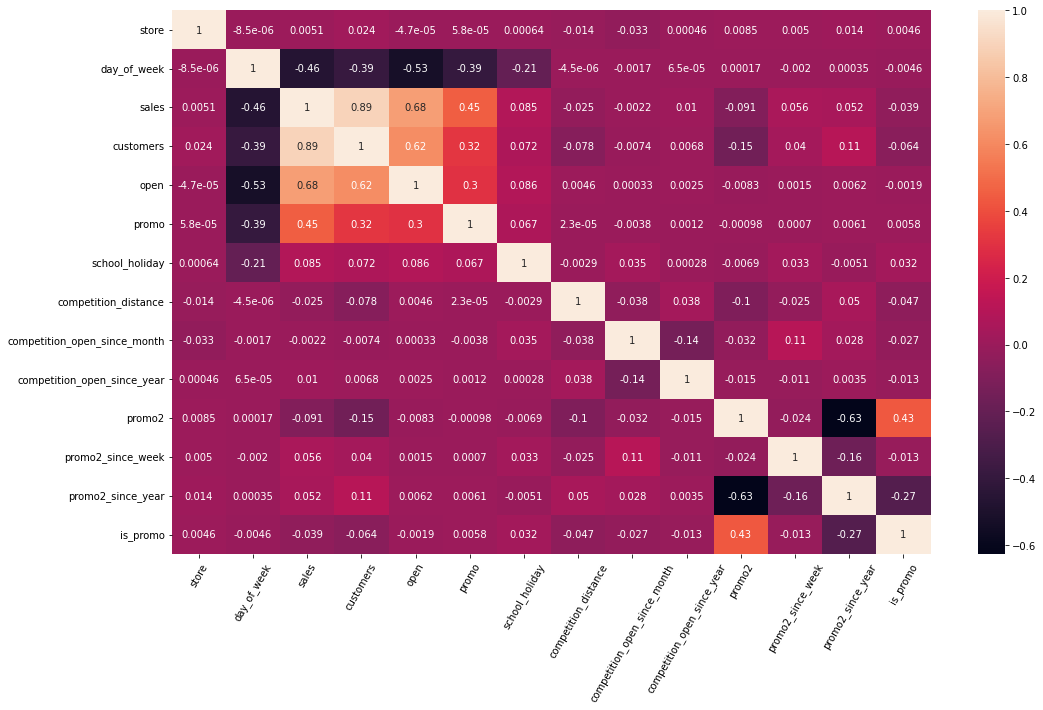

In [65]:
plt.figure( figsize=(17,10))
correlation = num_attributes.corr( method='pearson')
sns.heatmap( correlation, annot=True)
plt.xticks( rotation = 60)


### <font color="1318A3">4.3.2. Categorical Attributes</font>

<AxesSubplot:>

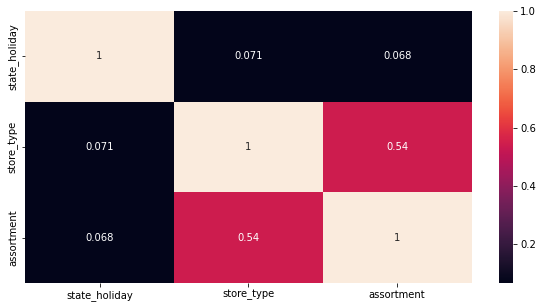

In [66]:
# correlation matrix
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate Creamer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9] })

d = d.set_index( d.columns )

plt.figure( figsize=(10,5))
sns.heatmap( d, annot=True)



# <font Color="1318A3">5.0 - DATA PREPARATION<font>

In [67]:
df5 = df4.copy()

## <font Color="1318A3"> 5.1. Normalizacao<font>

## <font Color="1318A3"> 5.2. Rescaling<font>

In [68]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)

df5['year'] = mms.fit_transform( df5[['year']].values)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

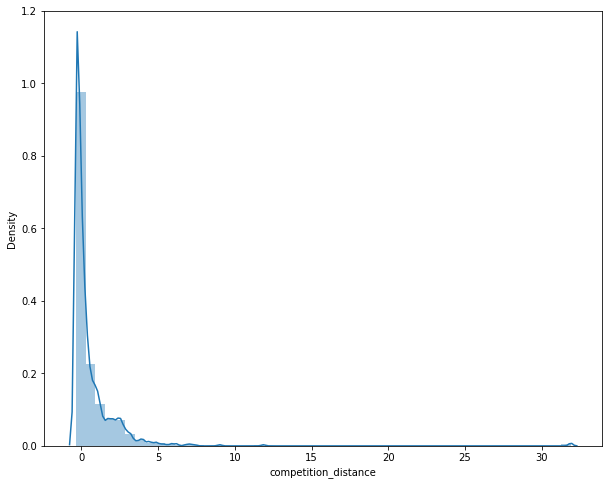

In [69]:
plt.figure( figsize=(10,8))
sns.distplot( df5['competition_distance'] )

### <font Color="1318A3"> 5.2.1. Rescaling - Save the Robust Scaller <font>

In [ ]:
# Save the Robust scaller (rs) for will use at the new Data

# competition_distance
pickle.dump( rs, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/parameters/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
pickle.dump( rs, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/parameters/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
pickle.dump( rs, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/parameters/promo_time_week_scaler.pkl', 'wb'))

# year
pickle.dump( mms, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/parameters/year_scaler.pkl', 'wb'))


## <font Color="1318A3"> 5.3. Transformation<font>

### <font Color="1318A3"> 5.3.1 Encoding<font>

In [70]:
# state_holiday -> São estados que mudam. One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

In [71]:
# store Type - label encoding
le = LabelEncoder()

df5['store_type'] =  le.fit_transform( df5['store_type'] )
pickle.dump( le, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/parameters/store_type_scaler.pkl', 'wb'))

In [ ]:
# Assortment -> tem um certo tipo de ordem.Encoding do tipo ordinal ( Ordinal ENconding)

In [72]:
# assortment - Original Encoding
assortment_dict={'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### <font Color="1318A3"> 5.3.2 Response Variable Transformation<font>

In [73]:
df5['sales'] = np.log1p(df5['sales'])

### <font Color="1318A3"> 5.3.2 Nature Transformation<font>

In [74]:
## Separando as variaveis que possuem natureza ciclica

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52)))


In [226]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


#  <font Color="1318A3">6.0 - FEATURE SELECTION<font>

In [75]:
df6 = df5.copy()

## <font Color="1318A3"> 6.1. Split dataframe into training and teste dataset <font>

In [77]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [79]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## <font Color="1318A3">6.2. Boruta as Features Selector<font>


In [80]:
# Training and Test dataset for Boruta
## X_train_n = X_train.drop(['date', 'sales'], axis=1).values
## y_train_n = y_train.values.ravel()

#define RandomForestRegressor
## rf = RandomForestRegressor( n_jobs=-1 )

# define Bortuta
## boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, y_train_n)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


## <font color="1318A3">6.2.1 Best Features from Boruta</font>

In [81]:
## cols_selected = boruta.support_.tolist()

# Best Features Seleciona as colunas relevantes
## X_train_fs = X_train.drop(['date', 'sales'], axis=1)
## cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
 
# not selected Boruta Colunas nao relevantes
## cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta) )


In [82]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [83]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [ ]:
# Vamos realizar a análise das hipoteses da secao 4 com o resultado do Boruta

In [84]:
tab = [['Hipotese', 'Conclusao', 'Relevancia'],
       ['H1', 'False', 'Baixa'],
       ['H2', 'False', 'Media'],
       ['H3', 'False', 'Media'],
       ['H4', 'False', 'Baixa'],
       ['H5', '-', '-'],
       ['H7', 'False', 'Baixa'],
       ['H8', 'False', 'Media'],
       ['H9', 'False', 'Alta'],
       ['H10', 'False', 'Alta'],
       ['H11', 'True', 'Alta'],
       ['H12', 'True', 'Alta'],
       ['H13', 'True', 'Baixa'],
      ]
print( tabulate( tab, headers = 'firstrow'))

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          False        Baixa
H2          False        Media
H3          False        Media
H4          False        Baixa
H5          -            -
H7          False        Baixa
H8          False        Media
H9          False        Alta
H10         False        Alta
H11         True         Alta
H12         True         Alta
H13         True         Baixa


## <font color="1318A3">6.3. Manual Features Selection</font>

In [85]:
# Relevant variables of the first Boruta model
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']
    
# Add date and sales columns
feat_to_add = ['date', 'sales']


In [86]:
# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# <font color="1318A3">7.0 - MACHINE LEARNING MODELLING</font>

In [87]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test[ cols_selected_boruta]

# Time Series Data Preparation
# x_training 
x_training = X_train[ cols_selected_boruta_full ]

## <font color="1318A3">7.1. Average Model</font>

In [88]:
# Average Model
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) ) 
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## <font color="1318A3">7.2. Linear Regression Model</font>

In [89]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## <font color="1318A3">7.3. Linear Regression Regularized Model - Lasso</font>

In [90]:
# Model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Prediction
yhat_lrr = lrr.predict( x_test )

# Performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## <font color="1318A3"> 7.4. Random Forest Regressor ( Algoritmo Nao Linear) </font>

In [91]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207


## <font color="1318A3">7.5. XGBoost Regressor ( Algoritmo Nao Linear) </font>

In [93]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train)
# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


## <font color="1318A3">7.2. Compare Model´s Performance</font>

### <font color="1318A3">7.2.1. Single Performance</font>

In [94]:
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### <font color="1318A3">7.2.2. Real Performance - Cross Validation</font>

In [102]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


### Alterando para deixar o Model Name como variável

In [ ]:
# model = LinearRegression()
model = Lasso( alpha=0.01)
a = cross_validation( x_training, 5, 'Lasso', model, verbose=True )

# <font color="1318A3">7.1 - MACHINE LEARNING - CROSS VALIDATION</font>

## <font color="1318A3">7.2.1. Linear Regression Model - Cross Validation</font>

In [109]:
# cross_validation( x_training, kfold, model_name, model, verbose=False)
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## <font color="1318A3">7.3.1. Linear Regression Regularized Model - Cross Validation - Lasso</font>

In [97]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## <font color="1318A3">7.4.1. Random Forest Regressor - Cross Validation</font>

In [110]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

CPU times: total: 0 ns
Wall time: 0 ns

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26


## <font color="1318A3">7.5.1. XGBoost Regressor - Cross Validation</font>

In [99]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


# <font color="1318A3">7.2. Compare Model´s Performance</font>

### <font color="1318A3">7.6.1. Single Performance</font>

In [100]:
modelling_result = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.881137,0.099945,1011.628207
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### <font color="1318A3">7.6.2. Real Performance - Cross Validation</font>

In [101]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.7 +/- 217.15,0.12 +/- 0.02,1254.34 +/- 316.26
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


# <font Color="1318A3">8.0 - HYPERPARAMETER FINE TUNING</font>

## <font Color="1318A3">8.1 Random Search</font>

In [206]:
# 'n_estimators': [ 1500, 1700, 2500, 3000, 3500 ],
param = {
         'n_estimators': [ 15, 17, 25, 30, 35 ],
         'eta': [ 0.01, 0.03 ],
         'max_depth': [ 3, 5, 9 ],
         'subsample': [ 0.1, 0.5, 0.7],
         'colsample_bytree':[ 0.3, 0.7, 0.9],
         'min_child_weight': [ 3, 8, 15]
         }

MAX_EVAL = 5 

In [207]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL):
    # Choose values for parameters randmly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
    # Model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )
   
    # Performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )
    
final_result    
    

{'n_estimators': 17, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 17, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 17, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 15, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 15, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7359.47 +/- 598.92,1.0 +/- 0.0,8012.26 +/- 698.47
0,XGBoost Regressor,7359.47 +/- 598.93,1.0 +/- 0.0,8012.25 +/- 698.47
0,XGBoost Regressor,7319.06 +/- 598.7,0.99 +/- 0.0,7974.49 +/- 698.4
0,XGBoost Regressor,7331.23 +/- 598.46,0.99 +/- 0.0,7985.63 +/- 698.1
0,XGBoost Regressor,7331.43 +/- 598.74,0.99 +/- 0.0,7986.17 +/- 698.37


## <font Color="1318A3">8.2 Final Model</font>

In [208]:

param_tuned = {
               'n_estimators':1700,
               'eta':0.03,
               'max_depth':9,
               'subsample':0.1,
               'colsample_bytree':0.9,
               'min_child_weight':15 
               }


In [209]:
# Model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, y_train)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

# Performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned
    

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,658.442261,0.096694,956.099178


In [ ]:
# Saving the Model
pickle.dump( model_xgb_tuned, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/model_result/model_rossmann.pkl', 'wb'))

# <font Color="1318A3">9.0 - CONVERT MODEL PERFORMANCE TO BUSINESS VALUES</font>

In [210]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale - Dados na escala logaritmica, precisa voltar para ter os dados originais

df9['sale'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )


## <font Color="1318A3">9.1 Business Performance</font>

In [211]:
# sum of predictions
df91 =df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]



In [227]:
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
1113,1114,785126.2500,763916.645767,806335.854233,21209.604233,2113.766993
816,817,743928.9375,723832.674686,764025.200314,20096.262814,2017.478505
261,262,843766.3125,824153.781528,863378.843472,19612.530972,1967.185667
841,842,679004.1875,660662.631510,697345.743490,18341.555990,1848.373365
250,251,662381.5000,644489.117712,680273.882288,17892.382288,1818.528495


<AxesSubplot:xlabel='store', ylabel='MAPE'>

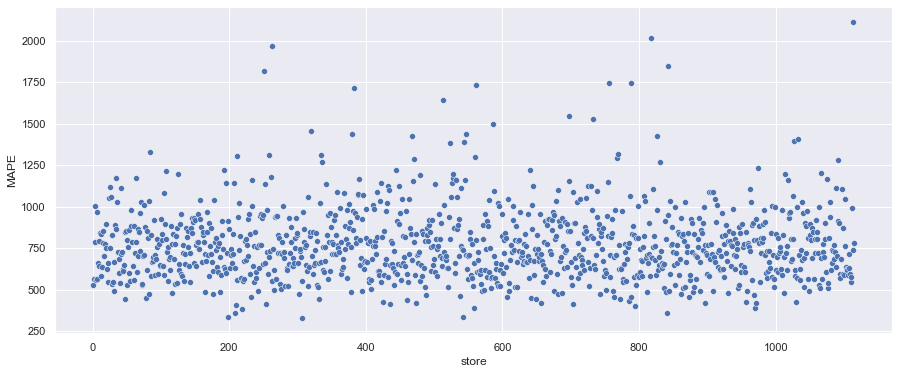

In [213]:
# scatter plot store x MAPE
plt.figure( figsize=(15,6))
sns.scatterplot( x='store', y='MAPE', data=df92)

## <font Color="1318A3">9.2 Total Performance</font>

In [214]:

df93 = df92[[ 'predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0 ).reset_index().rename(columns ={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '$ {:,.2f}'.format)
df93


,Scenario,Values
0,predictions,"$ 285,377,280.00"
1,worst_scenario,"$ 277,708,636.19"
2,best_scenario,"$ 293,045,909.19"


## <font Color="1318A3">9.3 Machine Learning Performance</font>

In [215]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


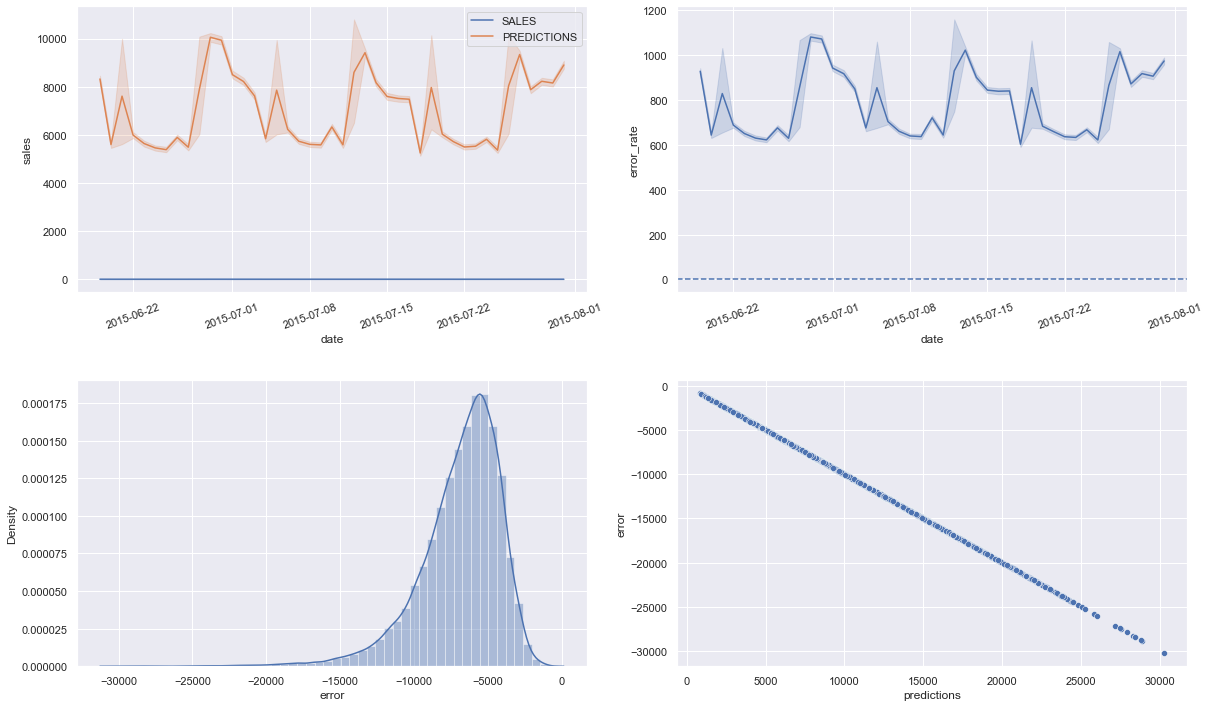

In [234]:
# chart perdictions per sales
plt.figure( figsize=(17,10))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')
plt.xticks( rotation = 20);

# Char error rate per date
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')
plt.xticks( rotation = 20)

# chart error distribution
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# chart  error prediction
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

plt.tight_layout(w_pad=2., h_pad=3.)

In [ ]:
# Save Fine Tunning Trained Model
pickle.dump( model_xgb_tuned, open('C:/Users/frmoriya/Documents/repos/ds_producao_hosmann/model_result/model_rossmann.pkl', 'wb'))